In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_privacy
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras import layers
from keras import backend as K
tf.random.set_seed(42)

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32)/255
test_data = np.array(test_data, dtype=np.float32)/255

train_data = train_data.reshape(train_data.shape[0],28,28,1) # angka 1 dibelakang menunjukkan color channel. Hanya ada 1 color channel
test_data = test_data.reshape(test_data.shape[0],28,28,1)

train_labels = np.array(train_labels, dtype = np.int32)
test_labels = np.array(test_labels, dtype = np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = 10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = 10)

#check data distribution, normalized since divided by 255
assert train_data.min() == 0
assert train_data.max() == 1
assert test_data.min() == 0
assert test_data.max() == 1

## Defining Functions

In [3]:
def dp_sgd(l2_norm_clip,noise_multiplier,num_microbatches,learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,8,
                              strides = 2,
                              padding = 'same',
                              activation = 'relu',
                              input_shape = (28,28,1)),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Conv2D(32,4,
                               strides = 2,
                               padding = 'valid',
                               activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip = l2_norm_clip,
        noise_multiplier = noise_multiplier,
        num_microbatches = num_microbatches,
        learning_rate = learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False, reduction = tf.losses.Reduction.NONE)
    model.compile(optimizer = optimizer , loss = loss, metrics = ['accuracy'])
    return model

def getlayeroutput(model,data,index):
    from keras import backend as K
    getoutput = K.function([model.layers[0].input],[model.layers[index].output])
    return getoutput([data])[0]

def discriminator(in_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(in_shape*1.25,input_dim = in_shape,
                              activation = 'relu'),
        tf.keras.layers.Dense(in_shape*2,input_dim = in_shape,activation = 'relu'),
        tf.keras.layers.Dense(in_shape*1.5,activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = 200,
    decay_rate = 0.96,
    staircase = True)
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                 metrics = 'accuracy')
    return model

def discriminatortrue(in_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(in_shape*1.25,input_dim = in_shape,
                              activation = 'linear'),
        tf.keras.layers.Dense(in_shape*2,activation = 'relu'),
        tf.keras.layers.Dense(in_shape*1.5,activation = 'linear'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(in_shape*2,activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                 metrics = 'accuracy')
    return model

def generator(in_shape):
    model = tf.keras.Sequential([
        #tf.keras.layers.Dense(16,input_dim = in_shape),
        tf.keras.layers.Conv1D(10,2,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv1D(20,2,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv1D(30,2,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(25,activation='linear'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(in_shape,activation='relu'),
    ])
    return model
    
def GAN(gen,dis):
    dis.trainable = False
    model = tf.keras.Sequential([ 
        gen,
        dis
    ])
    opt = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy',optimizer=opt)
    
    return model


def generate_fake_samples(gen, data, batch):
    x_input = np.random.randn(batch,data.shape[1])
    x_input = np.expand_dims(x_input, axis=2)
    x = gen.predict(x_input)
    y = np.zeros((batch,1))
    
    return x.reshape(batch,data.shape[1]),y

def shuffledata(xdata,ydata):
    indices = tf.range(start=0,limit=tf.shape(xdata)[0], dtype = tf.int32)
    idx = tf.random.shuffle(indices)
    return tf.gather(xdata,idx) , tf.gather(ydata,idx)

def train(gen, dis, distrue, gan, output_noise, output_true, n_epochs= 10000, n_batch = 512):
    #determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch/2)
    dishist=[]
    genhist=[]
    disacchist = []
    distrueacchist = []
    
    ### HUGE NOTE: Normalmodel is 1, DPmodel is 0
    
    #train the true discriminator to the DPmodel and Normalmodel data
    distrue_output_true_train_x = output_true[:] #setting x data from normalmodel for true discriminant
    distrue_output_true_train_y = np.ones((output_true.shape[0],1)) #setting y data from normalmodel for true discriminant
    
    distrue_output_noise_train_x = output_noise[:] #setting x data from DPmodel for true discriminant
    distrue_output_noise_train_y = np.zeros((output_noise.shape[0],1)) #setting y data from DPmodel for true discriminant
    
    #combine
    distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
    distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_shuffle, distruey_shuffle = shuffledata(distruex,distruey)
    distrue.fit(distruex_shuffle,distruey_shuffle)
    
    #manually enumerate epochs
    for epoch in range(n_epochs):
        ###########################################################################################################      
        ##GAN PART
        #prepare samples      
        #Normalmodel data
        x_real = output_true[np.random.choice(output_true.shape[0], half_batch, replace=False), :]
        y_real = np.ones((half_batch,1))
        
        #Normalmodel data upsampled (fake)
        x_fake, y_fake = generate_fake_samples(gen, output_true, half_batch)
        
        #combined
        disx = pd.DataFrame(x_real).append(pd.DataFrame(x_fake),ignore_index = True).to_numpy()
        disy = pd.DataFrame(y_real).append(pd.DataFrame(y_fake),ignore_index = True).to_numpy()
        
        #shuffle
        disx_shuffle, disy_shuffle = shuffledata(disx,disy)
        
        #update discriminator
        disloss, disacc = dis.train_on_batch(disx_shuffle,disy_shuffle)
        
        #input for gan
        noise = np.random.randn(n_batch,output_true.shape[1])
        noise = np.expand_dims(noise, axis=2)
        y_gen = np.ones((n_batch,1))
        
        #update generator from discriminator error
        gen_loss_fake = gan.train_on_batch(noise,y_gen)
        
        ###########################################################################################################
        ##TRUE DISCRIMINANT PART
        #Check the true discriminator performance
        #Normalmodel data upsampled (fake)
        distrue_output_true_x = x_fake[:]
        distrue_output_true_y = y_fake[:]
        distrue_output_true_y[:] = 1
    
        #DPmodel data
        distrue_output_noise_x = output_noise[np.random.choice(output_noise.shape[0], half_batch, replace=False), :]
        distrue_output_noise_y = np.zeros((distrue_output_true_y.shape[0],0))
        
        #aggregated
        distruex_test = pd.DataFrame(distrue_output_true_x).append(pd.DataFrame(distrue_output_noise_x),ignore_index = True).to_numpy()
        distruey_test = pd.DataFrame(distrue_output_true_y).append(pd.DataFrame(distrue_output_noise_y),ignore_index = True).to_numpy()
        
        
        distrueloss, distrueacc = distrue.test_on_batch(distruex_test,distruey_test)
        
        print('>%d, discriminant_loss=%.3f discriminant_acc=%.3f generator_loss=%.3f true_discriminant_acc=%.3f' % (epoch+1, disloss, disacc, gen_loss_fake, distrueacc))
        
        dishist.append(disloss)
        genhist.append(gen_loss_fake)
        disacchist.append(disacc)
        distrueacchist.append(distrueacc)
    plot_history(dishist,genhist,disacchist,distrueacchist)
    
    #final accuracy of True Discriminant
    output_true_upsampled_x, output_true_upsampled_y = generate_fake_samples(gen, output_true, output_true.shape[0])
    output_true_upsampled_y[:] = 1
    
    output_noise_x, output_noise_y = output_noise[:], np.zeros((output_noise.shape[0],1))
    
    distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
    distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_final_shuffle, distruey_final_shuffle = shuffledata(distruex_final,distruey_final)
    
    fin_loss, fin_acc = distrue.test_on_batch(distruex_final_shuffle, distruey_final_shuffle)
    
    print("Final True Discriminant Accuracy: %.3f" % fin_acc)
        
        
def plot_history(d_hist, g_hist, dacc_hist, dacc2_hist):
    # plot loss    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(d_hist, label='discriminator_loss')
    plt.plot(g_hist, label='generator_loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.subplot(212)
    plt.plot(dacc_hist, label='GAN_discriminator_accuracy')
    plt.plot(dacc2_hist, label='True_discriminator_accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.show()
    plt.close()

## Training Original Model 

##### DPmodel & Normalmodel

In [4]:
DPmodel = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 1, 
                 num_microbatches = 50, learning_rate = 0.25)
Normalmodel = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 1, 
                 num_microbatches = 50, learning_rate = 0.25)

DPmodel.fit(train_data, train_labels, 
            epochs = 5, batch_size = 250,
            validation_data = (test_data, test_labels))

Normalmodel.fit(train_data, train_labels, 
                epochs = 5, batch_size = 250,
                validation_data = (test_data, test_labels))

Epoch 1/5
240/240 [==============================] - 33s 102ms/step - loss: 0.7556 - accuracy: 0.7640 - val_loss: 0.3732 - val_accuracy: 0.9071
Epoch 2/5
240/240 [==============================] - 24s 101ms/step - loss: 0.4395 - accuracy: 0.8980 - val_loss: 0.4440 - val_accuracy: 0.9075
Epoch 3/5
240/240 [==============================] - 24s 102ms/step - loss: 0.5459 - accuracy: 0.8933 - val_loss: 0.5584 - val_accuracy: 0.9055
Epoch 4/5
240/240 [==============================] - 24s 101ms/step - loss: 0.6712 - accuracy: 0.8989 - val_loss: 0.6796 - val_accuracy: 0.9103
Epoch 5/5
240/240 [==============================] - 24s 102ms/step - loss: 0.7521 - accuracy: 0.9021 - val_loss: 0.7340 - val_accuracy: 0.9184
Epoch 1/5
240/240 [==============================] - 26s 100ms/step - loss: 0.7731 - accuracy: 0.7583 - val_loss: 0.4295 - val_accuracy: 0.8857
Epoch 2/5
240/240 [==============================] - 24s 98ms/step - loss: 0.4363 - accuracy: 0.8989 - val_loss: 0.4276 - val_accuracy: 

##### DP Model Privacy

In [5]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=250,
                                              noise_multiplier=1.6,
                                              epochs=5,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1.6 iterated over 1200 steps satisfies differential privacy with eps = 0.422 and delta = 1e-05.
The optimal RDP order is 27.0.


(0.4223191547406633, 27.0)

##### Normal Model Privacy

In [6]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=250,
                                              noise_multiplier=1,
                                              epochs=5,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 1200 steps satisfies differential privacy with eps = 1.13 and delta = 1e-05.
The optimal RDP order is 10.0.


(1.1278495014370558, 10.0)

## Proceed with GAN

In [7]:
output_model_noise = DPmodel.predict(train_data)
output_model_true = Normalmodel.predict(train_data)

1875/1875 [==============================] - 5s 3ms/step


C:\Windows\Temp\ipykernel_30840\1440043405.py:130: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_30840\1440043405.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()


8/8 [==============================] - 0s 3ms/step


C:\Windows\Temp\ipykernel_30840\1440043405.py:150: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  disx = pd.DataFrame(x_real).append(pd.DataFrame(x_fake),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_30840\1440043405.py:151: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  disy = pd.DataFrame(y_real).append(pd.DataFrame(y_fake),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_30840\1440043405.py:180: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_test = pd.DataFrame(distrue_output_true_x).append(pd.DataFrame(distrue_output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_30840\1440043405.py:181: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

>1, discriminant_loss=0.683 discriminant_acc=0.531 generator_loss=0.692 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>2, discriminant_loss=0.684 discriminant_acc=0.512 generator_loss=0.691 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>3, discriminant_loss=0.682 discriminant_acc=0.549 generator_loss=0.687 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>4, discriminant_loss=0.685 discriminant_acc=0.533 generator_loss=0.684 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>5, discriminant_loss=0.682 discriminant_acc=0.535 generator_loss=0.678 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>6, discriminant_loss=0.680 discriminant_acc=0.555 generator_loss=0.676 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>7, discriminant_loss=0.680 discriminant_acc=0.574 generator_loss=0.673 true_discriminant_acc=

8/8 [==============================] - 0s 3ms/step
>55, discriminant_loss=0.603 discriminant_acc=0.729 generator_loss=1.362 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>56, discriminant_loss=0.629 discriminant_acc=0.734 generator_loss=1.378 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>57, discriminant_loss=0.662 discriminant_acc=0.635 generator_loss=1.363 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>58, discriminant_loss=0.734 discriminant_acc=0.473 generator_loss=1.204 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>59, discriminant_loss=0.784 discriminant_acc=0.402 generator_loss=1.065 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>60, discriminant_loss=0.870 discriminant_acc=0.299 generator_loss=1.089 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>61, discriminant_loss=0.931 discrimi

8/8 [==============================] - 0s 3ms/step
>109, discriminant_loss=0.566 discriminant_acc=0.891 generator_loss=0.709 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>110, discriminant_loss=0.576 discriminant_acc=0.848 generator_loss=0.674 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>111, discriminant_loss=0.599 discriminant_acc=0.807 generator_loss=0.633 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>112, discriminant_loss=0.612 discriminant_acc=0.715 generator_loss=0.668 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>113, discriminant_loss=0.652 discriminant_acc=0.627 generator_loss=0.639 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>114, discriminant_loss=0.703 discriminant_acc=0.539 generator_loss=0.574 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>115, discriminant_loss=0.780 d

8/8 [==============================] - 0s 3ms/step
>163, discriminant_loss=0.603 discriminant_acc=0.648 generator_loss=1.344 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>164, discriminant_loss=0.605 discriminant_acc=0.635 generator_loss=1.331 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>165, discriminant_loss=0.620 discriminant_acc=0.650 generator_loss=1.259 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>166, discriminant_loss=0.628 discriminant_acc=0.662 generator_loss=1.180 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>167, discriminant_loss=0.651 discriminant_acc=0.646 generator_loss=1.146 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>168, discriminant_loss=0.646 discriminant_acc=0.672 generator_loss=1.071 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>169, discriminant_loss=0.665 d

8/8 [==============================] - 0s 3ms/step
>217, discriminant_loss=0.717 discriminant_acc=0.578 generator_loss=0.809 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>218, discriminant_loss=0.714 discriminant_acc=0.592 generator_loss=0.814 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>219, discriminant_loss=0.715 discriminant_acc=0.578 generator_loss=0.808 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>220, discriminant_loss=0.710 discriminant_acc=0.580 generator_loss=0.808 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>221, discriminant_loss=0.716 discriminant_acc=0.576 generator_loss=0.808 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>222, discriminant_loss=0.711 discriminant_acc=0.584 generator_loss=0.818 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>223, discriminant_loss=0.703 d

8/8 [==============================] - 0s 3ms/step
>271, discriminant_loss=0.698 discriminant_acc=0.615 generator_loss=0.751 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>272, discriminant_loss=0.695 discriminant_acc=0.650 generator_loss=0.751 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>273, discriminant_loss=0.689 discriminant_acc=0.672 generator_loss=0.750 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>274, discriminant_loss=0.688 discriminant_acc=0.695 generator_loss=0.745 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>275, discriminant_loss=0.687 discriminant_acc=0.678 generator_loss=0.746 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>276, discriminant_loss=0.682 discriminant_acc=0.658 generator_loss=0.743 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>277, discriminant_loss=0.682 d

8/8 [==============================] - 0s 3ms/step
>325, discriminant_loss=0.639 discriminant_acc=0.746 generator_loss=0.716 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>326, discriminant_loss=0.645 discriminant_acc=0.742 generator_loss=0.716 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>327, discriminant_loss=0.643 discriminant_acc=0.775 generator_loss=0.716 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>328, discriminant_loss=0.639 discriminant_acc=0.760 generator_loss=0.720 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>329, discriminant_loss=0.627 discriminant_acc=0.814 generator_loss=0.717 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>330, discriminant_loss=0.635 discriminant_acc=0.803 generator_loss=0.717 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>331, discriminant_loss=0.633 d

8/8 [==============================] - 0s 3ms/step
>379, discriminant_loss=0.624 discriminant_acc=0.520 generator_loss=0.661 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>380, discriminant_loss=0.627 discriminant_acc=0.512 generator_loss=0.652 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>381, discriminant_loss=0.632 discriminant_acc=0.492 generator_loss=0.626 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>382, discriminant_loss=0.631 discriminant_acc=0.504 generator_loss=0.628 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>383, discriminant_loss=0.646 discriminant_acc=0.473 generator_loss=0.606 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>384, discriminant_loss=0.649 discriminant_acc=0.473 generator_loss=0.618 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>385, discriminant_loss=0.655 d

8/8 [==============================] - 0s 3ms/step
>433, discriminant_loss=0.559 discriminant_acc=0.828 generator_loss=0.945 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>434, discriminant_loss=0.570 discriminant_acc=0.801 generator_loss=0.956 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>435, discriminant_loss=0.568 discriminant_acc=0.793 generator_loss=0.922 true_discriminant_acc=0.477
8/8 [==============================] - 0s 4ms/step
>436, discriminant_loss=0.569 discriminant_acc=0.818 generator_loss=0.890 true_discriminant_acc=0.289
8/8 [==============================] - 0s 3ms/step
>437, discriminant_loss=0.567 discriminant_acc=0.824 generator_loss=0.912 true_discriminant_acc=0.008
8/8 [==============================] - 0s 3ms/step
>438, discriminant_loss=0.564 discriminant_acc=0.805 generator_loss=0.892 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>439, discriminant_loss=0.571 d

8/8 [==============================] - 0s 3ms/step
>487, discriminant_loss=0.682 discriminant_acc=0.547 generator_loss=1.609 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>488, discriminant_loss=0.663 discriminant_acc=0.561 generator_loss=1.682 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>489, discriminant_loss=0.661 discriminant_acc=0.561 generator_loss=1.806 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>490, discriminant_loss=0.655 discriminant_acc=0.566 generator_loss=1.843 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>491, discriminant_loss=0.657 discriminant_acc=0.584 generator_loss=1.908 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>492, discriminant_loss=0.677 discriminant_acc=0.568 generator_loss=1.851 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>493, discriminant_loss=0.647 d

8/8 [==============================] - 0s 3ms/step
>541, discriminant_loss=0.765 discriminant_acc=0.604 generator_loss=0.704 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>542, discriminant_loss=0.776 discriminant_acc=0.613 generator_loss=0.705 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>543, discriminant_loss=0.764 discriminant_acc=0.586 generator_loss=0.712 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>544, discriminant_loss=0.768 discriminant_acc=0.607 generator_loss=0.716 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>545, discriminant_loss=0.762 discriminant_acc=0.590 generator_loss=0.715 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>546, discriminant_loss=0.766 discriminant_acc=0.568 generator_loss=0.714 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>547, discriminant_loss=0.749 d

8/8 [==============================] - 0s 3ms/step
>595, discriminant_loss=0.618 discriminant_acc=0.721 generator_loss=0.822 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>596, discriminant_loss=0.613 discriminant_acc=0.725 generator_loss=0.827 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>597, discriminant_loss=0.633 discriminant_acc=0.693 generator_loss=0.814 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>598, discriminant_loss=0.622 discriminant_acc=0.707 generator_loss=0.823 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>599, discriminant_loss=0.611 discriminant_acc=0.740 generator_loss=0.813 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>600, discriminant_loss=0.633 discriminant_acc=0.703 generator_loss=0.809 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>601, discriminant_loss=0.607 d

8/8 [==============================] - 0s 3ms/step
>649, discriminant_loss=0.682 discriminant_acc=0.557 generator_loss=1.097 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>650, discriminant_loss=0.648 discriminant_acc=0.561 generator_loss=1.117 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>651, discriminant_loss=0.640 discriminant_acc=0.564 generator_loss=1.203 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>652, discriminant_loss=0.633 discriminant_acc=0.559 generator_loss=1.198 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>653, discriminant_loss=0.627 discriminant_acc=0.543 generator_loss=1.283 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>654, discriminant_loss=0.589 discriminant_acc=0.584 generator_loss=1.279 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>655, discriminant_loss=0.609 d

8/8 [==============================] - 0s 3ms/step
>703, discriminant_loss=0.689 discriminant_acc=0.609 generator_loss=0.844 true_discriminant_acc=0.375
8/8 [==============================] - 0s 4ms/step
>704, discriminant_loss=0.673 discriminant_acc=0.637 generator_loss=0.845 true_discriminant_acc=0.455
8/8 [==============================] - 0s 4ms/step
>705, discriminant_loss=0.688 discriminant_acc=0.574 generator_loss=0.845 true_discriminant_acc=0.482
8/8 [==============================] - 0s 3ms/step
>706, discriminant_loss=0.687 discriminant_acc=0.568 generator_loss=0.838 true_discriminant_acc=0.482
8/8 [==============================] - 0s 3ms/step
>707, discriminant_loss=0.672 discriminant_acc=0.582 generator_loss=0.832 true_discriminant_acc=0.494
8/8 [==============================] - 0s 3ms/step
>708, discriminant_loss=0.668 discriminant_acc=0.639 generator_loss=0.829 true_discriminant_acc=0.498
8/8 [==============================] - 0s 4ms/step
>709, discriminant_loss=0.660 d

8/8 [==============================] - 0s 3ms/step
>757, discriminant_loss=0.675 discriminant_acc=0.596 generator_loss=0.749 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>758, discriminant_loss=0.674 discriminant_acc=0.607 generator_loss=0.750 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>759, discriminant_loss=0.669 discriminant_acc=0.598 generator_loss=0.754 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>760, discriminant_loss=0.672 discriminant_acc=0.598 generator_loss=0.755 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>761, discriminant_loss=0.666 discriminant_acc=0.604 generator_loss=0.752 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>762, discriminant_loss=0.665 discriminant_acc=0.621 generator_loss=0.753 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>763, discriminant_loss=0.658 d

8/8 [==============================] - 0s 3ms/step
>811, discriminant_loss=0.611 discriminant_acc=0.727 generator_loss=0.737 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>812, discriminant_loss=0.615 discriminant_acc=0.740 generator_loss=0.737 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>813, discriminant_loss=0.611 discriminant_acc=0.727 generator_loss=0.736 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>814, discriminant_loss=0.607 discriminant_acc=0.746 generator_loss=0.737 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>815, discriminant_loss=0.607 discriminant_acc=0.721 generator_loss=0.735 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>816, discriminant_loss=0.600 discriminant_acc=0.740 generator_loss=0.735 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>817, discriminant_loss=0.612 d

8/8 [==============================] - 0s 3ms/step
>865, discriminant_loss=0.548 discriminant_acc=0.764 generator_loss=0.686 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>866, discriminant_loss=0.580 discriminant_acc=0.707 generator_loss=0.699 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>867, discriminant_loss=0.560 discriminant_acc=0.748 generator_loss=0.681 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>868, discriminant_loss=0.568 discriminant_acc=0.732 generator_loss=0.671 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>869, discriminant_loss=0.572 discriminant_acc=0.723 generator_loss=0.664 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>870, discriminant_loss=0.577 discriminant_acc=0.711 generator_loss=0.644 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>871, discriminant_loss=0.572 d

8/8 [==============================] - 0s 3ms/step
>919, discriminant_loss=0.766 discriminant_acc=0.430 generator_loss=0.784 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>920, discriminant_loss=0.715 discriminant_acc=0.479 generator_loss=0.829 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>921, discriminant_loss=0.696 discriminant_acc=0.471 generator_loss=0.956 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>922, discriminant_loss=0.682 discriminant_acc=0.471 generator_loss=0.989 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>923, discriminant_loss=0.664 discriminant_acc=0.482 generator_loss=1.092 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>924, discriminant_loss=0.645 discriminant_acc=0.502 generator_loss=1.126 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>925, discriminant_loss=0.654 d

8/8 [==============================] - 0s 3ms/step
>973, discriminant_loss=0.657 discriminant_acc=0.623 generator_loss=0.946 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>974, discriminant_loss=0.665 discriminant_acc=0.598 generator_loss=0.939 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>975, discriminant_loss=0.667 discriminant_acc=0.615 generator_loss=0.947 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>976, discriminant_loss=0.670 discriminant_acc=0.619 generator_loss=0.919 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>977, discriminant_loss=0.674 discriminant_acc=0.594 generator_loss=0.914 true_discriminant_acc=0.490
8/8 [==============================] - 0s 4ms/step
>978, discriminant_loss=0.683 discriminant_acc=0.578 generator_loss=0.888 true_discriminant_acc=0.029
8/8 [==============================] - 0s 3ms/step
>979, discriminant_loss=0.684 d

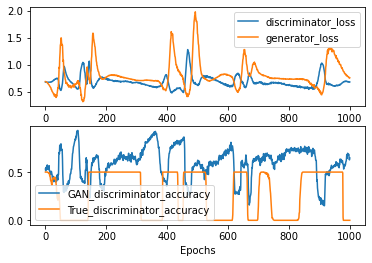

1875/1875 [==============================] - 5s 3ms/step


C:\Windows\Temp\ipykernel_30840\1440043405.py:200: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_30840\1440043405.py:201: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()


Final True Discriminant Accuracy: 0.094
8/8 [==============================] - 0s 3ms/step
>1, discriminant_loss=0.701 discriminant_acc=0.488 generator_loss=0.726 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>2, discriminant_loss=0.700 discriminant_acc=0.490 generator_loss=0.722 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>3, discriminant_loss=0.699 discriminant_acc=0.529 generator_loss=0.714 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>4, discriminant_loss=0.699 discriminant_acc=0.516 generator_loss=0.711 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>5, discriminant_loss=0.697 discriminant_acc=0.508 generator_loss=0.708 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>6, discriminant_loss=0.697 discriminant_acc=0.449 generator_loss=0.705 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>7,

8/8 [==============================] - 0s 3ms/step
>54, discriminant_loss=0.748 discriminant_acc=0.527 generator_loss=0.588 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>55, discriminant_loss=0.723 discriminant_acc=0.570 generator_loss=0.667 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>56, discriminant_loss=0.714 discriminant_acc=0.646 generator_loss=0.731 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>57, discriminant_loss=0.705 discriminant_acc=0.684 generator_loss=0.772 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>58, discriminant_loss=0.651 discriminant_acc=0.670 generator_loss=0.877 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>59, discriminant_loss=0.629 discriminant_acc=0.660 generator_loss=0.884 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>60, discriminant_loss=0.601 discrimi

8/8 [==============================] - 0s 3ms/step
>108, discriminant_loss=0.658 discriminant_acc=0.727 generator_loss=0.880 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>109, discriminant_loss=0.659 discriminant_acc=0.760 generator_loss=0.861 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>110, discriminant_loss=0.668 discriminant_acc=0.715 generator_loss=0.838 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>111, discriminant_loss=0.676 discriminant_acc=0.686 generator_loss=0.816 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>112, discriminant_loss=0.674 discriminant_acc=0.686 generator_loss=0.805 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>113, discriminant_loss=0.686 discriminant_acc=0.613 generator_loss=0.792 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>114, discriminant_loss=0.685 d

8/8 [==============================] - 0s 3ms/step
>162, discriminant_loss=0.652 discriminant_acc=0.705 generator_loss=0.722 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>163, discriminant_loss=0.647 discriminant_acc=0.754 generator_loss=0.722 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>164, discriminant_loss=0.645 discriminant_acc=0.762 generator_loss=0.725 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>165, discriminant_loss=0.648 discriminant_acc=0.732 generator_loss=0.723 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>166, discriminant_loss=0.635 discriminant_acc=0.768 generator_loss=0.722 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>167, discriminant_loss=0.646 discriminant_acc=0.746 generator_loss=0.725 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>168, discriminant_loss=0.645 d

8/8 [==============================] - 0s 3ms/step
>216, discriminant_loss=0.633 discriminant_acc=0.764 generator_loss=0.742 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>217, discriminant_loss=0.629 discriminant_acc=0.760 generator_loss=0.747 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>218, discriminant_loss=0.623 discriminant_acc=0.773 generator_loss=0.750 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>219, discriminant_loss=0.625 discriminant_acc=0.771 generator_loss=0.741 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>220, discriminant_loss=0.617 discriminant_acc=0.768 generator_loss=0.750 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>221, discriminant_loss=0.616 discriminant_acc=0.775 generator_loss=0.750 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>222, discriminant_loss=0.609 d

8/8 [==============================] - 0s 4ms/step
>270, discriminant_loss=0.415 discriminant_acc=0.918 generator_loss=0.947 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>271, discriminant_loss=0.430 discriminant_acc=0.904 generator_loss=0.955 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>272, discriminant_loss=0.430 discriminant_acc=0.916 generator_loss=0.933 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>273, discriminant_loss=0.406 discriminant_acc=0.938 generator_loss=0.900 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>274, discriminant_loss=0.434 discriminant_acc=0.910 generator_loss=0.925 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>275, discriminant_loss=0.435 discriminant_acc=0.895 generator_loss=0.901 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>276, discriminant_loss=0.436 d

8/8 [==============================] - 0s 4ms/step
>324, discriminant_loss=0.769 discriminant_acc=0.324 generator_loss=0.776 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>325, discriminant_loss=0.764 discriminant_acc=0.314 generator_loss=0.801 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>326, discriminant_loss=0.737 discriminant_acc=0.357 generator_loss=0.807 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>327, discriminant_loss=0.728 discriminant_acc=0.605 generator_loss=0.819 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>328, discriminant_loss=0.707 discriminant_acc=0.635 generator_loss=0.851 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>329, discriminant_loss=0.693 discriminant_acc=0.617 generator_loss=0.867 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>330, discriminant_loss=0.667 d

8/8 [==============================] - 0s 3ms/step
>378, discriminant_loss=0.722 discriminant_acc=0.533 generator_loss=1.133 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>379, discriminant_loss=0.703 discriminant_acc=0.572 generator_loss=1.099 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>380, discriminant_loss=0.711 discriminant_acc=0.570 generator_loss=1.056 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>381, discriminant_loss=0.722 discriminant_acc=0.580 generator_loss=1.015 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>382, discriminant_loss=0.715 discriminant_acc=0.588 generator_loss=1.001 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>383, discriminant_loss=0.713 discriminant_acc=0.598 generator_loss=0.966 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>384, discriminant_loss=0.705 d

8/8 [==============================] - 0s 3ms/step
>432, discriminant_loss=0.748 discriminant_acc=0.318 generator_loss=0.692 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>433, discriminant_loss=0.734 discriminant_acc=0.340 generator_loss=0.710 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>434, discriminant_loss=0.738 discriminant_acc=0.320 generator_loss=0.716 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>435, discriminant_loss=0.730 discriminant_acc=0.340 generator_loss=0.720 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>436, discriminant_loss=0.714 discriminant_acc=0.363 generator_loss=0.728 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>437, discriminant_loss=0.720 discriminant_acc=0.377 generator_loss=0.774 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>438, discriminant_loss=0.678 d

8/8 [==============================] - 0s 3ms/step
>486, discriminant_loss=0.629 discriminant_acc=0.529 generator_loss=0.634 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>487, discriminant_loss=0.667 discriminant_acc=0.445 generator_loss=0.639 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>488, discriminant_loss=0.708 discriminant_acc=0.410 generator_loss=0.607 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>489, discriminant_loss=0.711 discriminant_acc=0.396 generator_loss=0.592 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>490, discriminant_loss=0.730 discriminant_acc=0.410 generator_loss=0.615 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>491, discriminant_loss=0.766 discriminant_acc=0.385 generator_loss=0.589 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>492, discriminant_loss=0.818 d

8/8 [==============================] - 0s 3ms/step
>540, discriminant_loss=0.617 discriminant_acc=0.576 generator_loss=1.316 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>541, discriminant_loss=0.629 discriminant_acc=0.590 generator_loss=1.262 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>542, discriminant_loss=0.631 discriminant_acc=0.598 generator_loss=1.231 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>543, discriminant_loss=0.630 discriminant_acc=0.619 generator_loss=1.206 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>544, discriminant_loss=0.652 discriminant_acc=0.580 generator_loss=1.072 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>545, discriminant_loss=0.656 discriminant_acc=0.613 generator_loss=1.080 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>546, discriminant_loss=0.674 d

8/8 [==============================] - 0s 3ms/step
>594, discriminant_loss=0.670 discriminant_acc=0.760 generator_loss=0.815 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>595, discriminant_loss=0.674 discriminant_acc=0.740 generator_loss=0.815 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>596, discriminant_loss=0.666 discriminant_acc=0.738 generator_loss=0.816 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>597, discriminant_loss=0.649 discriminant_acc=0.787 generator_loss=0.814 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>598, discriminant_loss=0.653 discriminant_acc=0.775 generator_loss=0.817 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>599, discriminant_loss=0.664 discriminant_acc=0.754 generator_loss=0.815 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>600, discriminant_loss=0.647 d

8/8 [==============================] - 0s 3ms/step
>648, discriminant_loss=0.575 discriminant_acc=0.846 generator_loss=0.845 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>649, discriminant_loss=0.585 discriminant_acc=0.840 generator_loss=0.842 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>650, discriminant_loss=0.575 discriminant_acc=0.846 generator_loss=0.837 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>651, discriminant_loss=0.580 discriminant_acc=0.830 generator_loss=0.845 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>652, discriminant_loss=0.581 discriminant_acc=0.824 generator_loss=0.841 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>653, discriminant_loss=0.578 discriminant_acc=0.836 generator_loss=0.841 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>654, discriminant_loss=0.570 d

8/8 [==============================] - 0s 3ms/step
>702, discriminant_loss=0.523 discriminant_acc=0.836 generator_loss=0.833 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>703, discriminant_loss=0.533 discriminant_acc=0.832 generator_loss=0.836 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>704, discriminant_loss=0.538 discriminant_acc=0.832 generator_loss=0.836 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>705, discriminant_loss=0.542 discriminant_acc=0.816 generator_loss=0.847 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>706, discriminant_loss=0.525 discriminant_acc=0.832 generator_loss=0.850 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>707, discriminant_loss=0.528 discriminant_acc=0.830 generator_loss=0.843 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>708, discriminant_loss=0.545 d

8/8 [==============================] - 0s 3ms/step
>756, discriminant_loss=0.497 discriminant_acc=0.820 generator_loss=0.801 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>757, discriminant_loss=0.491 discriminant_acc=0.830 generator_loss=0.793 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>758, discriminant_loss=0.499 discriminant_acc=0.807 generator_loss=0.763 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>759, discriminant_loss=0.491 discriminant_acc=0.809 generator_loss=0.782 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>760, discriminant_loss=0.478 discriminant_acc=0.830 generator_loss=0.778 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>761, discriminant_loss=0.471 discriminant_acc=0.840 generator_loss=0.776 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>762, discriminant_loss=0.481 d

8/8 [==============================] - 0s 3ms/step
>810, discriminant_loss=0.689 discriminant_acc=0.492 generator_loss=0.598 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>811, discriminant_loss=0.721 discriminant_acc=0.477 generator_loss=0.661 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>812, discriminant_loss=0.727 discriminant_acc=0.480 generator_loss=0.628 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>813, discriminant_loss=0.743 discriminant_acc=0.500 generator_loss=0.674 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>814, discriminant_loss=0.799 discriminant_acc=0.453 generator_loss=0.724 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>815, discriminant_loss=0.801 discriminant_acc=0.457 generator_loss=0.706 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>816, discriminant_loss=0.778 d

8/8 [==============================] - 0s 3ms/step
>864, discriminant_loss=0.976 discriminant_acc=0.350 generator_loss=0.412 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>865, discriminant_loss=0.955 discriminant_acc=0.361 generator_loss=0.406 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>866, discriminant_loss=0.927 discriminant_acc=0.334 generator_loss=0.430 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>867, discriminant_loss=0.905 discriminant_acc=0.348 generator_loss=0.462 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>868, discriminant_loss=0.871 discriminant_acc=0.344 generator_loss=0.455 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>869, discriminant_loss=0.807 discriminant_acc=0.430 generator_loss=0.492 true_discriminant_acc=0.008
8/8 [==============================] - 0s 3ms/step
>870, discriminant_loss=0.791 d

8/8 [==============================] - 0s 3ms/step
>918, discriminant_loss=1.155 discriminant_acc=0.252 generator_loss=0.432 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>919, discriminant_loss=1.112 discriminant_acc=0.246 generator_loss=0.469 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>920, discriminant_loss=1.054 discriminant_acc=0.250 generator_loss=0.483 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>921, discriminant_loss=0.995 discriminant_acc=0.248 generator_loss=0.505 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>922, discriminant_loss=0.949 discriminant_acc=0.242 generator_loss=0.542 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>923, discriminant_loss=0.896 discriminant_acc=0.242 generator_loss=0.563 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>924, discriminant_loss=0.851 d

8/8 [==============================] - 0s 3ms/step
>972, discriminant_loss=0.651 discriminant_acc=0.639 generator_loss=1.180 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>973, discriminant_loss=0.657 discriminant_acc=0.617 generator_loss=1.171 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>974, discriminant_loss=0.640 discriminant_acc=0.633 generator_loss=1.176 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>975, discriminant_loss=0.628 discriminant_acc=0.641 generator_loss=1.180 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>976, discriminant_loss=0.627 discriminant_acc=0.613 generator_loss=1.173 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>977, discriminant_loss=0.614 discriminant_acc=0.648 generator_loss=1.160 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>978, discriminant_loss=0.620 d

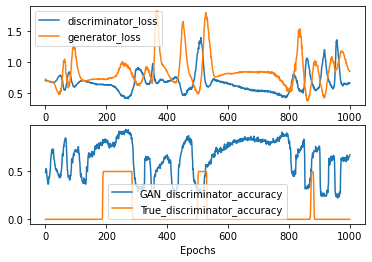

1875/1875 [==============================] - 5s 3ms/step
Final True Discriminant Accuracy: 0.447
8/8 [==============================] - 0s 2ms/step
>1, discriminant_loss=0.664 discriminant_acc=0.488 generator_loss=0.660 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>2, discriminant_loss=0.664 discriminant_acc=0.479 generator_loss=0.656 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>3, discriminant_loss=0.664 discriminant_acc=0.496 generator_loss=0.651 true_discriminant_acc=0.500
8/8 [==============================] - 0s 7ms/step
>4, discriminant_loss=0.662 discriminant_acc=0.504 generator_loss=0.640 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>5, discriminant_loss=0.667 discriminant_acc=0.486 generator_loss=0.639 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>6, discriminant_loss=0.669 discriminant_acc=0.480 generator_loss=0.628 true_discriminant_acc=0.5

8/8 [==============================] - 0s 3ms/step
>54, discriminant_loss=1.314 discriminant_acc=0.533 generator_loss=0.178 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>55, discriminant_loss=1.461 discriminant_acc=0.512 generator_loss=0.155 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>56, discriminant_loss=1.414 discriminant_acc=0.502 generator_loss=0.172 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>57, discriminant_loss=1.451 discriminant_acc=0.502 generator_loss=0.181 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>58, discriminant_loss=1.521 discriminant_acc=0.502 generator_loss=0.207 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>59, discriminant_loss=1.532 discriminant_acc=0.510 generator_loss=0.233 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>60, discriminant_loss=1.478 discrimi

8/8 [==============================] - 0s 3ms/step
>108, discriminant_loss=0.455 discriminant_acc=0.785 generator_loss=1.159 true_discriminant_acc=0.000
8/8 [==============================] - 0s 2ms/step
>109, discriminant_loss=0.457 discriminant_acc=0.811 generator_loss=1.183 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>110, discriminant_loss=0.482 discriminant_acc=0.816 generator_loss=1.085 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>111, discriminant_loss=0.496 discriminant_acc=0.840 generator_loss=0.986 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>112, discriminant_loss=0.541 discriminant_acc=0.787 generator_loss=0.845 true_discriminant_acc=0.000
8/8 [==============================] - 0s 5ms/step
>113, discriminant_loss=0.554 discriminant_acc=0.814 generator_loss=0.811 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>114, discriminant_loss=0.562 d

8/8 [==============================] - 0s 3ms/step
>162, discriminant_loss=0.643 discriminant_acc=0.680 generator_loss=0.787 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>163, discriminant_loss=0.638 discriminant_acc=0.660 generator_loss=0.903 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>164, discriminant_loss=0.649 discriminant_acc=0.658 generator_loss=0.817 true_discriminant_acc=0.000
8/8 [==============================] - 0s 4ms/step
>165, discriminant_loss=0.664 discriminant_acc=0.602 generator_loss=0.865 true_discriminant_acc=0.002
8/8 [==============================] - 0s 3ms/step
>166, discriminant_loss=0.694 discriminant_acc=0.551 generator_loss=0.824 true_discriminant_acc=0.031
8/8 [==============================] - 0s 3ms/step
>167, discriminant_loss=0.737 discriminant_acc=0.471 generator_loss=0.865 true_discriminant_acc=0.148
8/8 [==============================] - 0s 3ms/step
>168, discriminant_loss=0.785 d

8/8 [==============================] - 0s 3ms/step
>216, discriminant_loss=0.588 discriminant_acc=0.691 generator_loss=1.056 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>217, discriminant_loss=0.579 discriminant_acc=0.738 generator_loss=1.017 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>218, discriminant_loss=0.589 discriminant_acc=0.748 generator_loss=1.030 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>219, discriminant_loss=0.582 discriminant_acc=0.756 generator_loss=1.044 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>220, discriminant_loss=0.585 discriminant_acc=0.779 generator_loss=1.020 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>221, discriminant_loss=0.583 discriminant_acc=0.756 generator_loss=0.998 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>222, discriminant_loss=0.576 d

8/8 [==============================] - 0s 3ms/step
>270, discriminant_loss=0.708 discriminant_acc=0.412 generator_loss=0.694 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>271, discriminant_loss=0.706 discriminant_acc=0.432 generator_loss=0.691 true_discriminant_acc=0.500
8/8 [==============================] - 0s 4ms/step
>272, discriminant_loss=0.696 discriminant_acc=0.461 generator_loss=0.696 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>273, discriminant_loss=0.719 discriminant_acc=0.420 generator_loss=0.708 true_discriminant_acc=0.494
8/8 [==============================] - 0s 4ms/step
>274, discriminant_loss=0.706 discriminant_acc=0.406 generator_loss=0.701 true_discriminant_acc=0.475
8/8 [==============================] - 0s 3ms/step
>275, discriminant_loss=0.724 discriminant_acc=0.355 generator_loss=0.705 true_discriminant_acc=0.410
8/8 [==============================] - 0s 3ms/step
>276, discriminant_loss=0.715 d

In [ ]:
for i in range(0,5):
    disc2 = discriminatortrue(output_model_noise.shape[1])
    disc = discriminator(output_model_true.shape[1])
    gen = generator(output_model_true.shape[1])
    gan = GAN(gen,disc)
    train(gen,disc,disc2,gan,output_model_noise,output_model_true,n_epochs = 1000)

In [ ]:
noise = np.random.randn(output_model_noise.shape[0],output_model_noise.shape[1])
noise = np.expand_dims(noise, axis=2)
comparenoise = output_model_noise.flatten()
comparetrue = output_model_true.flatten()
comparefake = gen.predict(noise).flatten()
sns.kdeplot(comparenoise)
sns.kdeplot(comparetrue)
plt.legend(labels = ['comparenoise','comparetrue'])
plt.show()
sns.kdeplot(comparefake)
plt.legend(labels = 'comparefake')
plt.show()

In [ ]:
from scipy.stats import ttest_ind

ttest_ind(comparetrue,comparefake)

In [ ]:
sns.kdeplot(comparetrue)
sns.kdeplot(comparefake)
plt.legend(labels = ['comparetrue','comparefake'])